In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


# 1. Create spark session

In [2]:
spark = SparkSession.builder.appName("GBTClassifierExample").getOrCreate()

24/10/06 22:01:03 WARN Utils: Your hostname, Rosamelias-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.188 instead (on interface en0)
24/10/06 22:01:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/06 22:01:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/06 22:01:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 2. Read in data

In [3]:
df = spark.read.csv("data/Base.csv", header=True, inferSchema=True)

# 3. Remove not needed features
From EDA we saw that we should remove: 'device_fraud_count'

In [4]:
df = df.drop("device_fraud_count")

# 3. Address class imbalance

In [5]:
# calculate the class distribution
fraud_count = df.filter(df.fraud_bool == 1).count()
no_fraud_count = df.filter(df.fraud_bool == 0).count()

total_count = fraud_count + no_fraud_count
fraud_weight = total_count / (2.0 * fraud_count)  # minority class (fraud)
legit_weight = total_count / (2.0 * no_fraud_count)  # majority class (legit)

# create a weight column
df = df.withColumn("class_weight", F.when(df.fraud_bool == 1, fraud_weight).otherwise(legit_weight))


# 4. One-hot encoding
From EDA we already know which features are cat and which ones are num. Now, from the cat, we will only one-hot encode the ones that are not binary. These are: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [6]:
cat_features = ['payment_type',
'employment_status',
'housing_status',
'source',
'device_os',
'keep_alive_session',
'foreign_request',
'has_other_cards',
'phone_mobile_valid',
'phone_home_valid',
'email_is_free',
'customer_age']

one_hot_features = ['payment_type', 
'employment_status', 
'housing_status', 
'source', 
'device_os']

num_features = ['income',
'name_email_similarity',
'prev_address_months_count',
'current_address_months_count',
'days_since_request',
'intended_balcon_amount',
'zip_count_4w',
'velocity_6h',
'velocity_24h',
'velocity_4w',
'bank_branch_count_8w',
'date_of_birth_distinct_emails_4w',
'credit_risk_score',
'bank_months_count',
'proposed_credit_limit',
'session_length_in_minutes',
'device_distinct_emails_8w',
'month']

In [7]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in one_hot_features]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in one_hot_features]
encoded_cols = [col + "_encoded" for col in one_hot_features]

# assemble all the features into a single feature vector
assembler = VectorAssembler(inputCols=num_features + encoded_cols, outputCol="features")


# 4. Training
Define model, split data, create pipeline and fit the model. 

In [8]:
gbt = GBTClassifier(labelCol="fraud_bool", weightCol="class_weight", featuresCol="features", maxIter=10)
train_df, test_df = df.randomSplit([0.9, 0.1], seed=42) # same split and seed as in EDA 
pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])
gbt_model = pipeline.fit(train_df)

24/10/06 22:01:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/10/06 22:01:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/10/06 22:01:28 WARN MemoryStore: Not enough space to cache rdd_84_7 in memory! (computed 12.5 MiB so far)
24/10/06 22:01:28 WARN MemoryStore: Not enough space to cache rdd_84_2 in memory! (computed 8.3 MiB so far)
24/10/06 22:01:28 WARN MemoryStore: Not enough space to cache rdd_84_3 in memory! (computed 8.3 MiB so far)
24/10/06 22:01:28 WARN BlockManager: Persisting block rdd_84_7 to disk instead.
24/10/06 22:01:28 WARN BlockManager: Persisting block rdd_84_3 to disk instead.
24/10/06 22:01:28 WARN BlockManager: Persisting block rdd

# 5. Evaluation

In [9]:
predictions = gbt_model.transform(test_df)

## 5.1. AUC


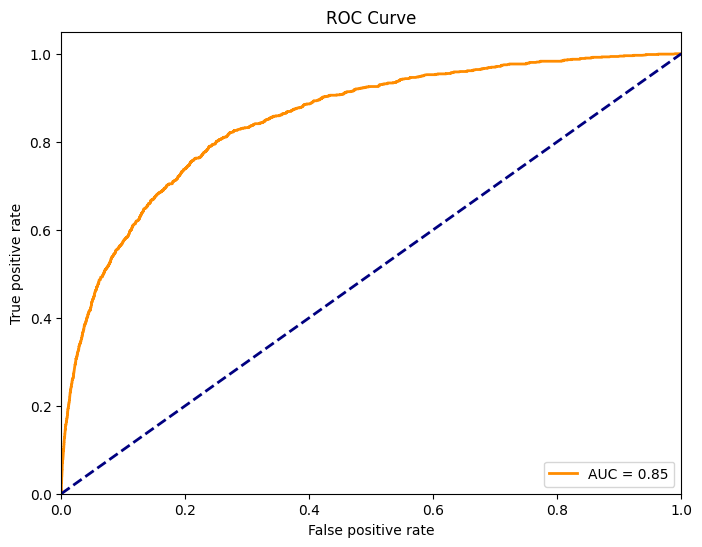

In [11]:
# extract true labels and predicted probabilities
predictions_pd = predictions.select("fraud_bool", "probability").toPandas()
predictions_pd["probability_class_1"] = predictions_pd["probability"].apply(lambda x: x[1])

# compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(predictions_pd["fraud_bool"], predictions_pd["probability_class_1"])
roc_auc = auc(fpr, tpr)

# plot 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 5.2. Precision, Recall and F1

In [12]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.996545017146952
Recall: 0.7876011326860841
F1-Score: 0.8708623599901907


## 5.3. Confusion matrix

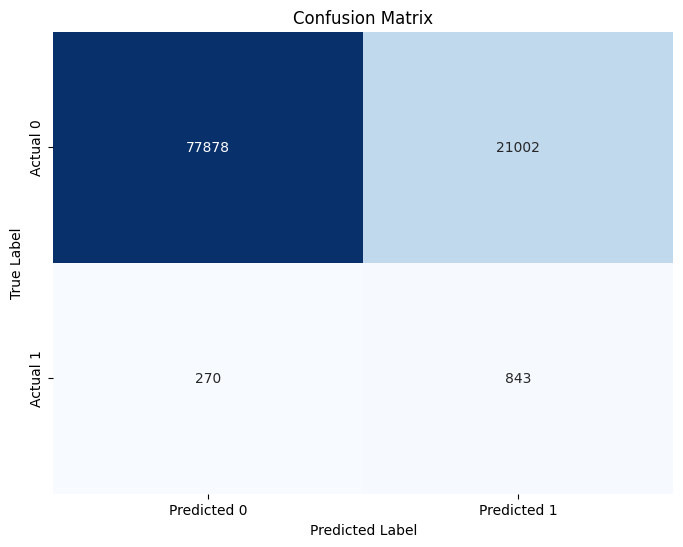

In [13]:
confusion_matrix = predictions.groupBy("fraud_bool", "prediction").count()
confusion_matrix_pd = confusion_matrix.toPandas()
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='fraud_bool', columns='prediction', values='count').fillna(0) # create the 2D matrix required by Seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 5.4. Example of predictions

In [14]:
predictions.select("fraud_bool", "prediction", "probability").show(10, truncate=False)


+----------+----------+----------------------------------------+
|fraud_bool|prediction|probability                             |
+----------+----------+----------------------------------------+
|0         |0.0       |[0.7248986523259914,0.2751013476740086] |
|0         |0.0       |[0.7485066636570598,0.25149333634294024]|
|0         |0.0       |[0.6808905018951734,0.3191094981048266] |
|0         |1.0       |[0.17322271967469885,0.8267772803253012]|
|0         |0.0       |[0.6515919300432033,0.34840806995679674]|
|0         |1.0       |[0.3384286396623705,0.6615713603376294] |
|0         |1.0       |[0.1950142440549285,0.8049857559450715] |
|0         |0.0       |[0.691545213716033,0.30845478628396705] |
|0         |0.0       |[0.7444232056964253,0.2555767943035747] |
|0         |0.0       |[0.8779428213428773,0.12205717865712273]|
+----------+----------+----------------------------------------+
only showing top 10 rows

